### **Chunk 2: Data Splitting & Basic Preprocessing**

#### **1. Concept Introduction**

-   **Data Splitting Revisited**: `train_test_split` is great for a quick validation, but a single split can be lucky or unlucky. The gold standard is **cross-validation**, where we split the data into multiple "folds" and train/test the model multiple times. This gives a much more robust estimate of model performance. We'll dive deep into this later, but for now, know that `train_test_split` is our primary tool for fast iteration.

-   **Why Preprocessing Matters**: Imagine you're building a model to predict house prices, and you have two features: `number_of_rooms` (from 1 to 10) and `square_footage` (from 500 to 5000). An algorithm that uses distance (like K-Nearest Neighbors) will be completely dominated by `square_footage`. A change of 100 sq ft will seem vastly more important than a change of 2 rooms, even if that isn't true. **Feature scaling** fixes this by putting all features on a common scale.

-   **Core Preprocessing Tools**:
    1.  `StandardScaler`: The most common scaler. It transforms each feature to have a mean of 0 and a standard deviation of 1. It assumes your data is normally distributed (a Gaussian distribution) and is not sensitive to outliers.
    2.  `MinMaxScaler`: Scales features to a fixed range, usually 0 to 1. It's useful when you need bounded values or if the data is not normally distributed. It can be sensitive to outliers.
    3.  `SimpleImputer`: Real-world data is often missing values (represented as `NaN`). You can't feed `NaN`s to a model. `SimpleImputer` is a basic strategy to fill them in, for example, with the mean, median, or most frequent value of the column.

The most critical rule of preprocessing is: **You must learn the scaling parameters (like the mean and standard deviation) from the training data ONLY.** Applying `.fit()` to the entire dataset before splitting is a form of **data leakage** and will give you an artificially optimistic performance estimate.

#### **2. Dataset EDA: The Wine Quality Dataset**

This dataset contains chemical properties of red wines and a quality score from 3 to 8. It's great for our purpose because the features are all numeric but have very different scales. Our goal will be to classify a wine as "good" (quality > 5) or "bad" (quality <= 5).


In [1]:
# IMports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

# Set plot style
sns.set_style("whitegrid")

**Load Data**

In [5]:
# Fetch the Wine Wuality dataset form OPenML
wine = fetch_openml(name='wine-quality-red',
            version='active',
            as_frame=True,
            parser='auto')
df = wine.frame

# Dataset info
print("Dataset info")
df.info()

Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed_acidity         1599 non-null   float64 
 1   volatile_acidity      1599 non-null   float64 
 2   citric_acid           1599 non-null   float64 
 3   residual_sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free_sulfur_dioxide   1599 non-null   float64 
 6   total_sulfur_dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  class                 1599 non-null   category
dtypes: category(1), float64(11)
memory usage: 139.3 KB


In [6]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


**Create Target Variable**

For this example, let's make it a binary classification problem.
Quality > 5 is 'good' ( 1 ), otherwise 'bad' ( 0 )

In [ ]:
df['class'] = pd.to_numeric(df['class'], errors='coerce')  # convert to numeric
df['quality_binary'] = (df['class'] > 5).astype(int)
df = df.drop('class', axis=1) # Drop the original multiclass target


In [11]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_binary
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0


**Basic Statistics**


In [12]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_binary
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.534709
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.498950
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


In [13]:
# First 5 rows
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [14]:
# Check for any missing values
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality_binary          0
dtype: int64

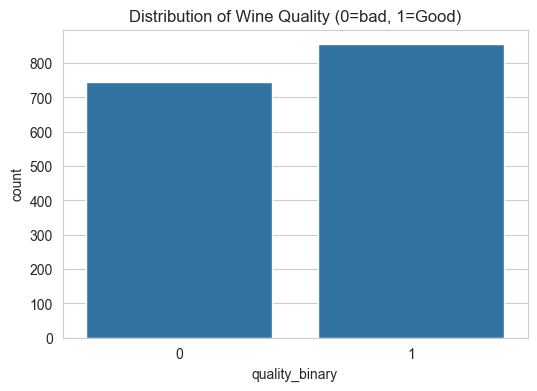

In [15]:
# Target Varibale Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='quality_binary', data=df)
plt.title("Distribution of Wine Quality (0=bad, 1=Good)")
plt.show()

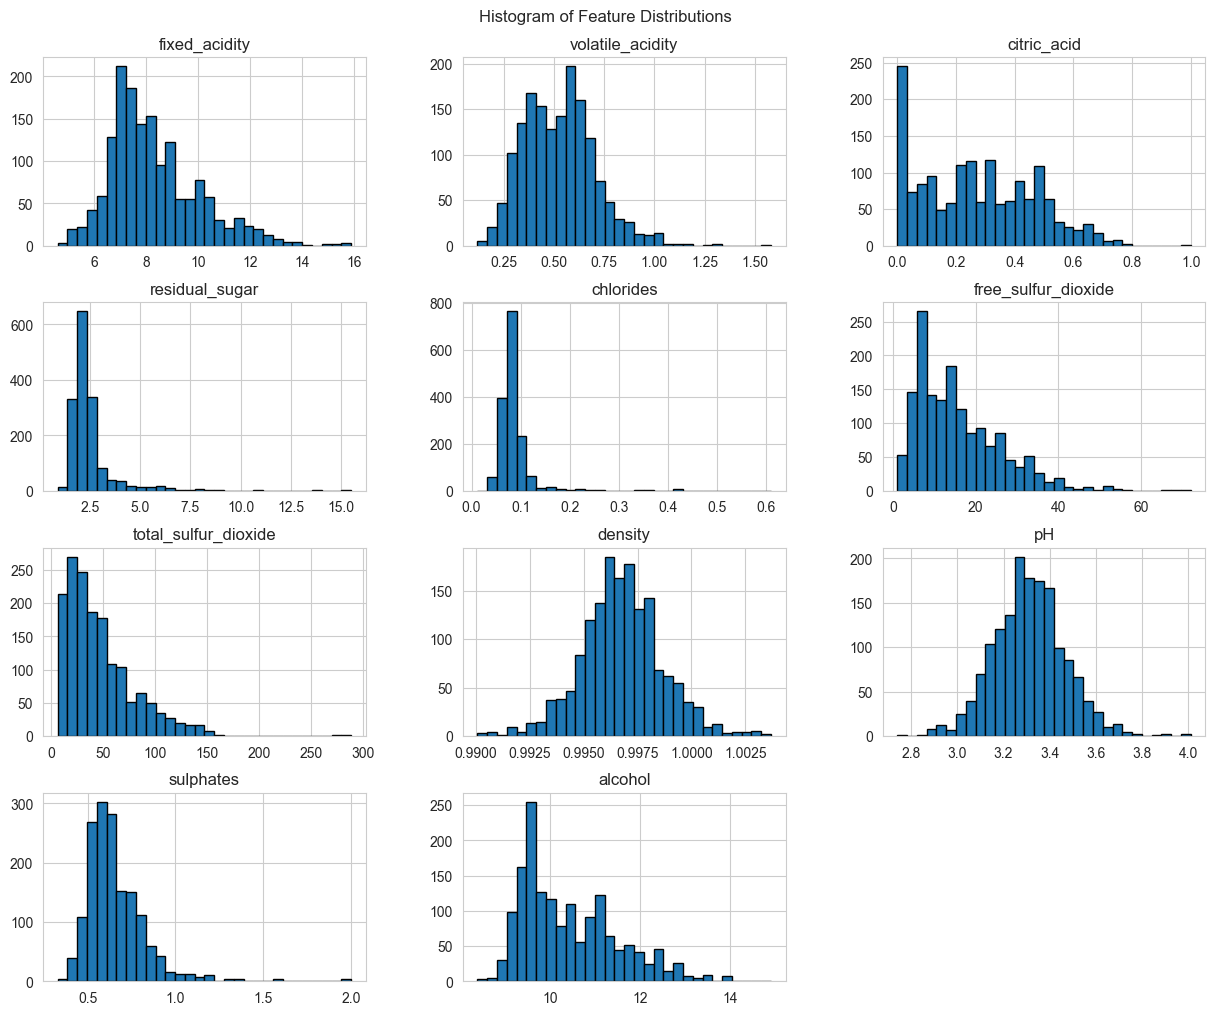

In [16]:
# Feature Distribution ( Histogram ) 
# This clearly shows the different scales and distributions of each feature
df.drop('quality_binary', axis=1).hist(figsize=(15, 12),
bins=30,
edgecolor='black')
plt.suptitle('Histogram of Feature Distributions', y=0.92)
plt.show()

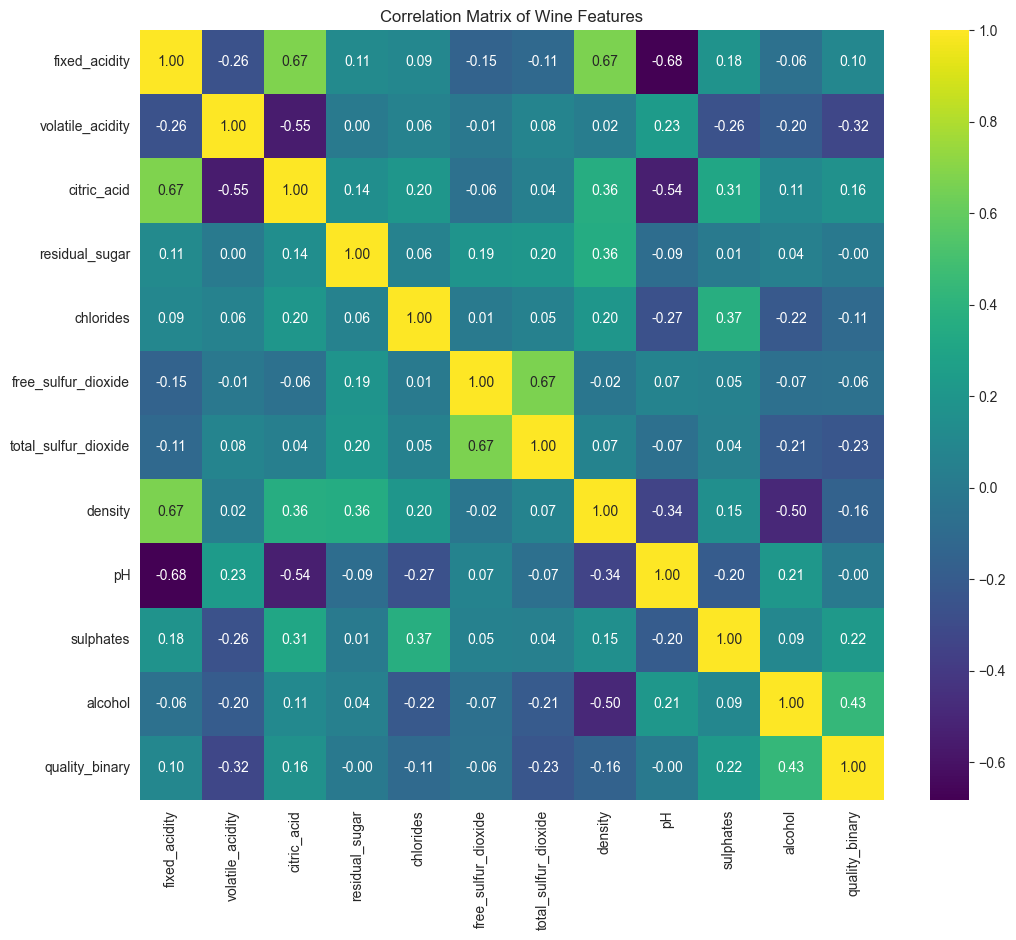

In [18]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12,10))
crlm = df.corr()
sns.heatmap(crlm, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Wine Features')
plt.show()

**3. Minimal Working Example: The Power of Scaling**

Let's see the dramatic effect of scaling on a K-Nearest Neighbors (KNN) model, which is highly sensitive to feature scales.

In [ ]:
# Imports, Data, Splitting
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

